### Imports and Helper Functions

In [3]:
# Python standard library
import os
from pathlib import Path
import pickle
import copy

# Computation
import numpy as np

# Visualization
from tqdm import tqdm
from matplotlib import colors
import matplotlib.pyplot as plt
from skimage.morphology import dilation, disk
from skimage.segmentation import find_boundaries

# Segmentation
import sis

In [4]:
%matplotlib inline

### Loading an experiment

The test data cannot be uploaded to github since they are too large, so you will have to download them from the brain image library using the `download_merscope_test_files.sh` script   

```
$ bash download_merscope_test_files.sh
```

In [5]:
# The downloadable data is a MERSCOPE experiment result
expt_path = Path(os.path.abspath('')) / "merscope_test_data/"
image_path = expt_path / 'images/'
csv_file = expt_path / 'detected_transcripts.csv'
cache_file = expt_path / 'detected_transcripts.csv.npz'

st = sis.SpotTable.load_merscope(csv_file=csv_file, cache_file=cache_file, image_path=image_path)

Loading from npz..


### Pick a small tile to test on

We will use a region of high cell density to demonstrate the improvement of the custom model over pretrained Cellpose models.

In [6]:
subrgn = ((2000, 2200), (1400, 1600))
sub_st = st.get_subregion(xlim=subrgn[0], ylim=subrgn[1])

Text(0.5, 1.0, 'Nuclear Stain')

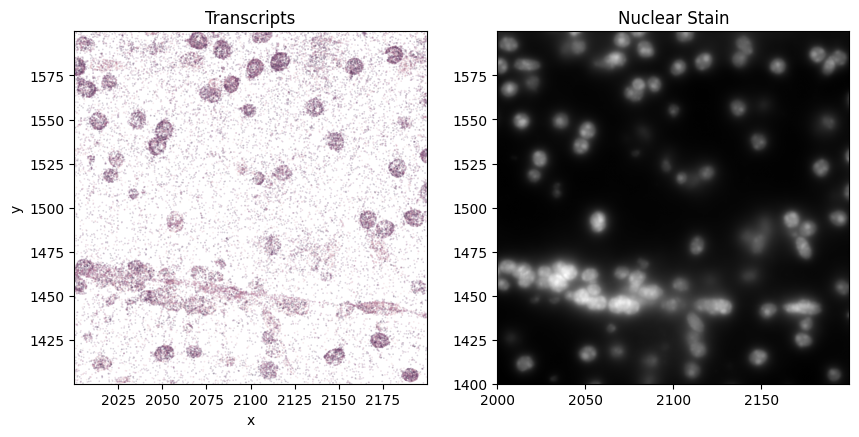

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sub_st.scatter_plot(ax=ax[0])
sub_st.get_image(channel='DAPI').show(ax=ax[1], frame='mean', cmap='gray')
ax[0].set_title('Transcripts')
ax[1].set_title('Nuclear Stain')

### Choose a custom Cellpose model for segmentation
#### Currently available finetuned models:
 - **CP_20240611_mousedev**: cyto model for total_mrna + nuclei, finetuned on 24 MERSCOPE images from 24 different brain sections (6 P0, 6 P4, 3 P20 M, 3 P20 F, 3 P28 M, 3 P28 F)
 - **cellpose_20230919_3species_merscope**: cyto model for total_mrna + nuclei, finetuned on 9 merscope images from 3 different species (3 macaque, 3 human, & 3 mouse). Generally works, but a finetuned, species-specific model will give better results

In [8]:
path_to_model = str(Path(os.path.abspath('')).parent / "models/CP_20240611_mousedev")

### Use custom model to segment a single (2D) slice

Note 1: if running segmentation on a two channel image, you must specify the frames for both channels

In [9]:
seg_opts_2d = {
                'region': None,
                'cellpose_model': path_to_model, # path (to custom model) or string (for pretrained model, e.g. 'cyto2')
                'cellpose_gpu': 'auto',
                'px_size': 0.108,          # um / px
                'cell_dia': 10,            # um (or None)
                'z_plane_thickness': 1.5,  # um
                'images': {
                    'nuclei': {'channel': 'DAPI', 'frames': 3},
                    'cyto': {'channel': 'total_mrna', 'n_planes': 7, 'frames': 3}
                }, 
                'cellpose_options': {
                    'batch_size': 8,
                }
              }

seg_custom_2d = sis.segmentation.CellposeSegmentationMethod(seg_opts_2d)
result_custom_2d = seg_custom_2d.run(sub_st)

Text(0.5, 1.0, 'Cellpose masks over DAPI stain')

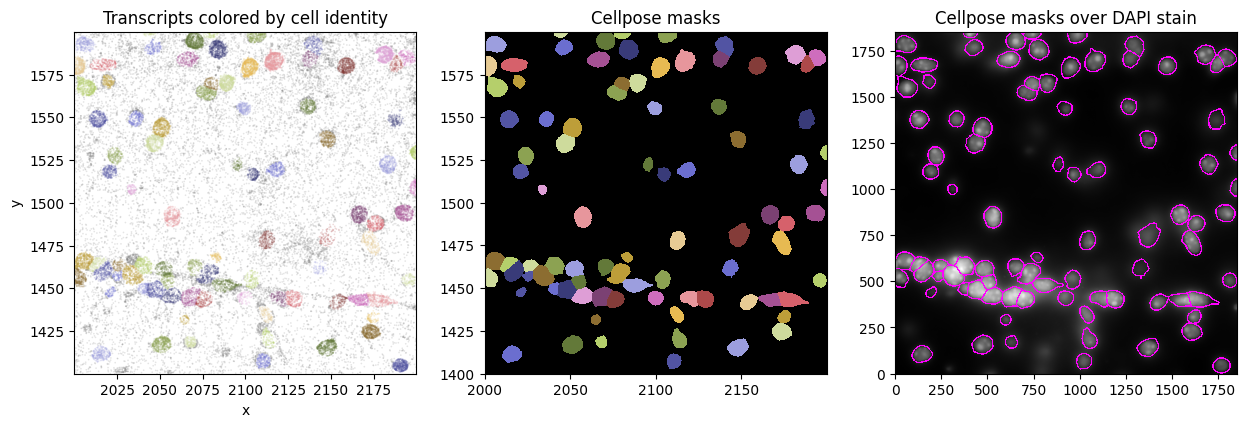

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Create colormap for cell ids
cmap_custom_2d = sis.util.get_cell_cmap(result_custom_2d.spot_table(), bg_color='black')

result_custom_2d.spot_table().cell_scatter_plot(ax=ax[0])
ax[0].set_title('Transcripts colored by cell identity')
result_custom_2d.mask_image.show(ax[1], cmap=cmap_custom_2d, interpolation='None')
ax[1].set_title('Cellpose masks')

cmap_transparent0 = colors.ListedColormap(['none', 'magenta'])
cyto_outlines = dilation(find_boundaries(result_custom_2d.mask_image.get_data()[0, ...]), footprint=disk(3))
ax[2].imshow(sub_st.get_image(channel='DAPI').get_frames(3).get_data()[0, ...], cmap='gray')
ax[2].imshow(cyto_outlines, cmap=cmap_transparent0, interpolation='nearest')
ax[2].invert_yaxis()
ax[2].set_title('Cellpose masks over DAPI stain')

### Compare to results of a pretrained Cellpose model

In [11]:
# Use all the same options except for the model
seg_opts_cyto = copy.deepcopy(seg_opts_2d)
seg_opts_cyto['cellpose_model'] = 'cyto2'

seg_cyto_2d = sis.segmentation.CellposeSegmentationMethod(seg_opts_cyto)
result_cyto_2d = seg_cyto_2d.run(sub_st)

Text(0.5, 1.0, 'Cellpose masks over DAPI stain')

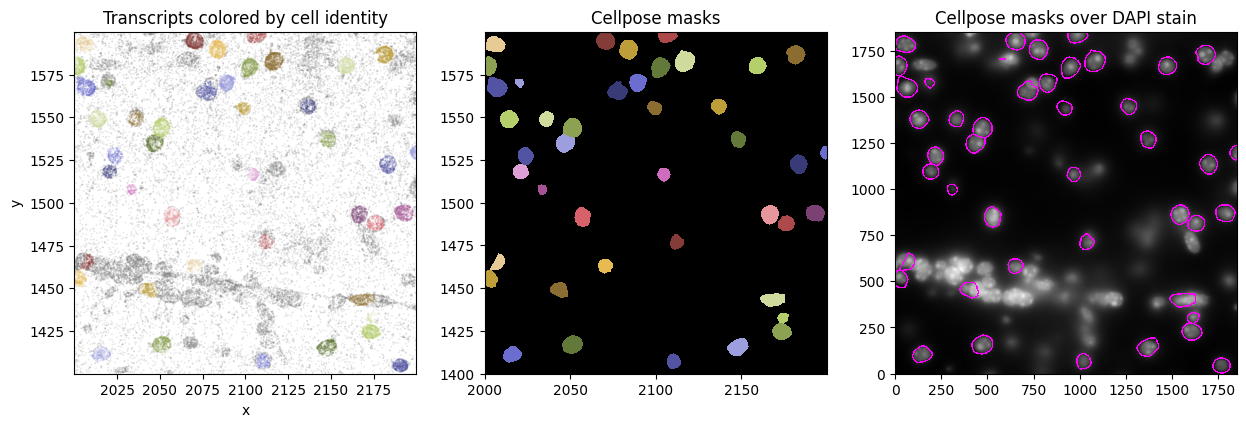

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Create colormap for cell ids
cmap_cyto_2d = sis.util.get_cell_cmap(result_cyto_2d.spot_table(), bg_color='black')

result_cyto_2d.spot_table().cell_scatter_plot(ax=ax[0])
ax[0].set_title('Transcripts colored by cell identity')
result_cyto_2d.mask_image.show(ax[1], cmap=cmap_cyto_2d, interpolation='None')
ax[1].set_title('Cellpose masks')

cmap_transparent0 = colors.ListedColormap(['none', 'magenta'])
cyto_outlines = dilation(find_boundaries(result_cyto_2d.mask_image.get_data()[0, ...]), footprint=disk(3))
ax[2].imshow(sub_st.get_image(channel='DAPI').get_frames(3).get_data()[0, ...], cmap='gray')
ax[2].imshow(cyto_outlines, cmap=cmap_transparent0, interpolation='nearest')
ax[2].invert_yaxis()
ax[2].set_title('Cellpose masks over DAPI stain')

#### Side-by-side comparison to two models

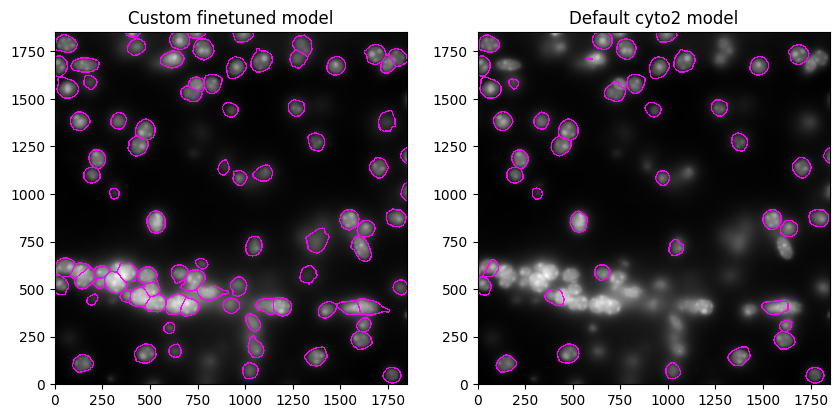

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

cmap_transparent0 = colors.ListedColormap(['none', 'magenta'])

cyto_outlines = dilation(find_boundaries(result_cyto_2d.mask_image.get_data()[0, ...]), footprint=disk(3))
custom_outlines = dilation(find_boundaries(result_custom_2d.mask_image.get_data()[0, ...]), footprint=disk(3))

ax[0].imshow(sub_st.get_image(channel='DAPI').get_frames(3).get_data()[0, ...], cmap='gray')
ax[0].imshow(custom_outlines, cmap=cmap_transparent0, interpolation='nearest')
ax[0].invert_yaxis()
ax[0].set_title('Custom finetuned model')

ax[1].imshow(sub_st.get_image(channel='DAPI').get_frames(3).get_data()[0, ...], cmap='gray')
ax[1].imshow(cyto_outlines, cmap=cmap_transparent0, interpolation='nearest')
ax[1].invert_yaxis()
ax[1].set_title('Default cyto2 model')

plt.show()

### Generating cell polygons from the SIS segmentation results

When we run segmentation across a whole section we are forced to tile the section due to memory constraints. Merging the resulting segmentation masks is a tricky endeavor since masks can differ between overlapping tiles. Because of this—in addition to the masks' large storage size—we merge segmentations based on transcript identities and calculate polygons after all tiles are merged. These shapely polygons are calculated from the transcript locations by finding the alpha shape with the largest alpha that still contains all transcripts. Of course, this is slightly less accurate than using the masks themselves, but if you have a reasonable transcript density, it should still be a pretty good estimation for the actual cells. These polygons can be calculated in 2D or 3D (a sequence of 2D polygons) using the `sis.SegmentedSpotTable.calculate_cell_polygons()`


Note: After the largest alpha still containing all transcripts is found, it is multiplied by a value between `0` and `1` to encourage a more natural cell shape. By default, this value is `3/4`

In [14]:
segmented_spot_table = result_custom_2d.spot_table()
segmented_spot_table.calculate_cell_polygons(separate_z_planes=False) # Since the data is 2D, we can set this to False

  0%|          | 0/87 [00:00<?, ?it/s]

In [15]:
# The actual polygons are stored in the `cell_polygons` attribute
segmented_spot_table.cell_polygons

{np.uint16(1): <POLYGON ((2186.353 1406.331, 2186.486 1406.593, 2187.856 1407.491, 2188.288...>,
 np.uint16(2): <POLYGON ((2107.71 1410.736, 2108.224 1411.262, 2109.255 1411.639, 2109.98 1...>,
 np.uint16(3): <POLYGON ((2010.21 1410.911, 2010.857 1413.262, 2011.368 1413.615, 2012.151 ...>,
 np.uint16(4): <POLYGON ((2141.73 1414.801, 2141.711 1415.624, 2142.397 1416.394, 2143.085 ...>,
 np.uint16(5): <POLYGON ((2046.331 1419.093, 2047.297 1420.581, 2048.07 1420.754, 2049.342 ...>,
 np.uint16(6): <POLYGON ((2110.395 1425.745, 2110.895 1425.992, 2111.85 1426.831, 2112.356 ...>,
 np.uint16(7): <POLYGON ((2064.645 1417.932, 2064.874 1419.148, 2064.79 1419.754, 2064.735 ...>,
 np.uint16(8): <POLYGON ((2168.219 1424.836, 2168.403 1426.924, 2168.659 1427.004, 2169.418...>,
 np.uint16(9): <POLYGON ((2063.316 1433.589, 2064 1433.963, 2065.505 1434.68, 2065.897 1433...>,
 np.uint16(10): <POLYGON ((2171.416 1433.495, 2171.657 1434.794, 2173.996 1435.438, 2174.138...>,
 np.uint16(11): <POLYGON ((21

In [16]:
# Polygons can be stored using the `save_polygons` method
# Additionally, the cell_by_gene_anndata and save_anndata methods can be used to save the data polygons in the uns of an anndata object representing the cell-by-gene matrix
os.mkdir(Path(os.path.abspath('')) / 'merscope_test_results')

segmented_spot_table.save_cell_polygons(Path(os.path.abspath('')) / 'merscope_test_results/cell_polygons.geojson')

segmented_spot_table.generate_cell_labels()
segmented_spot_table.save_anndata(Path(os.path.abspath('')) / 'merscope_test_results/cell_by_gene.h5ad',
                                  segmented_spot_table.cell_by_gene_anndata(x_format='dense'))

#### Plotting cell polygons

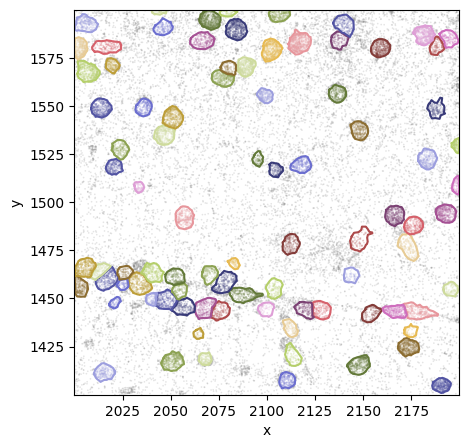

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
segmented_spot_table.cell_scatter_plot(ax=ax, show_polygons=True)

### Run custom Cellpose on a 3D stack

To run 3D segmentation, omit the frame argument.

Note: 3D Cellpose segmentation can be very slow without GPU access.

In [18]:
seg_opts_3d = {
                'region': None,
                'cellpose_model': path_to_model,
                'cellpose_gpu': 'auto',
                'px_size': 0.108,          # um / px
                'cell_dia': 10,            # um (or None)
                'z_plane_thickness': 1.5,  # um
                'images': { # The frame options in each of the image dictionaries
                    'nuclei': {'channel': 'DAPI'},
                    'cyto': {'channel': 'total_mrna', 'n_planes': 7} 
                }, 
                'cellpose_options': {
                    'batch_size': 8,
                    'min_size': 5000 # We use this to remove 3D segmentation artifacts
                }
              }

seg_custom_3d = sis.segmentation.CellposeSegmentationMethod(seg_opts_3d)
result_custom_3d = seg_custom_3d.run(sub_st)

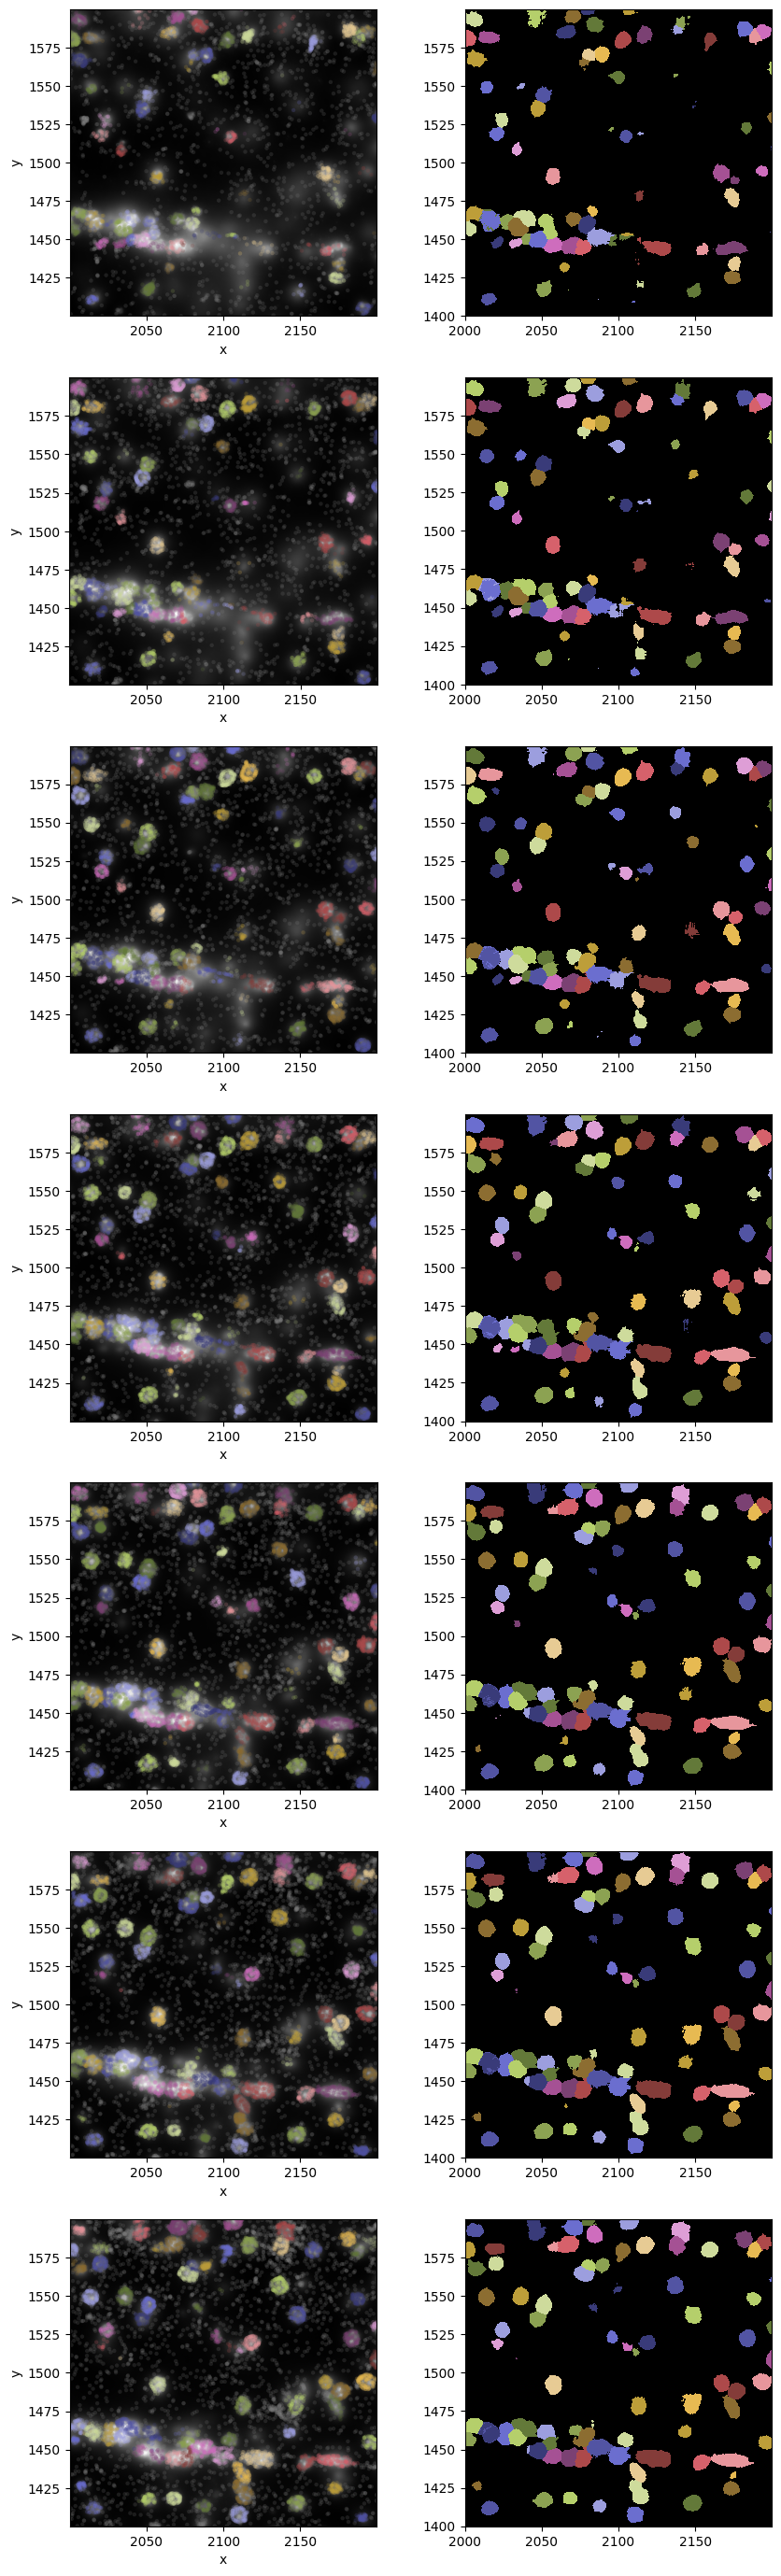

In [19]:
img = sub_st.get_image(channel='DAPI')
n_planes = img.shape[0]

fig, ax = plt.subplots(n_planes, 2, figsize=(10, 5*n_planes))

# Create colormap for cell ids
cmap_custom_3d = sis.util.get_cell_cmap(result_custom_3d.spot_table(), bg_color='black')

for i in range(n_planes):
    mask = sub_st.z == i
    result_custom_3d.spot_table()[mask].scatter_plot(ax=ax[i, 0], color='cell_ids', size=10)
    
    img_layer = img.get_frames(i)
    img_layer.show(ax[i, 0], cmap='gray')
    mask_layer = result_custom_3d.mask_image.get_frames(i)
    mask_layer.show(ax[i, 1], cmap=cmap_custom_3d, interpolation='None')

#### Calculating 3D polygons

In [20]:
segmented_spot_table = result_custom_3d.spot_table()
segmented_spot_table.calculate_cell_polygons() # calculate_cell_polygons creates 3D cell polygons by default 

  0%|          | 0/90 [00:00<?, ?it/s]

In [21]:
# 3D polygons are stored as a dictionary with float z-planes as keys and shapely Polygons as values
segmented_spot_table.cell_polygons[1]

{np.float32(0.0): <POLYGON ((2187.2 1405.712, 2187.653 1406.351, 2188.385 1407.729, 2189.028 1...>,
 np.float32(1.0): <POLYGON ((2187.635 1404.862, 2187.785 1406.972, 2189.133 1408.303, 2189.624...>,
 np.float32(2.0): <POLYGON ((2186.877 1405.918, 2187.073 1406.57, 2187.856 1407.491, 2188.288 ...>,
 np.float32(3.0): <POLYGON ((2186.823 1403.514, 2186.787 1404.154, 2186.816 1404.472, 2186.825...>,
 np.float32(4.0): <POLYGON ((2186.934 1404.287, 2186.435 1406.357, 2187.579 1406.427, 2188.839...>,
 np.float32(5.0): <POLYGON ((2185.972 1405.181, 2185.739 1406.543, 2185.468 1407.398, 2185.857...>,
 np.float32(6.0): <POLYGON ((2188.852 1407.901, 2190.092 1407.688, 2191.701 1408.063, 2192.655...>}

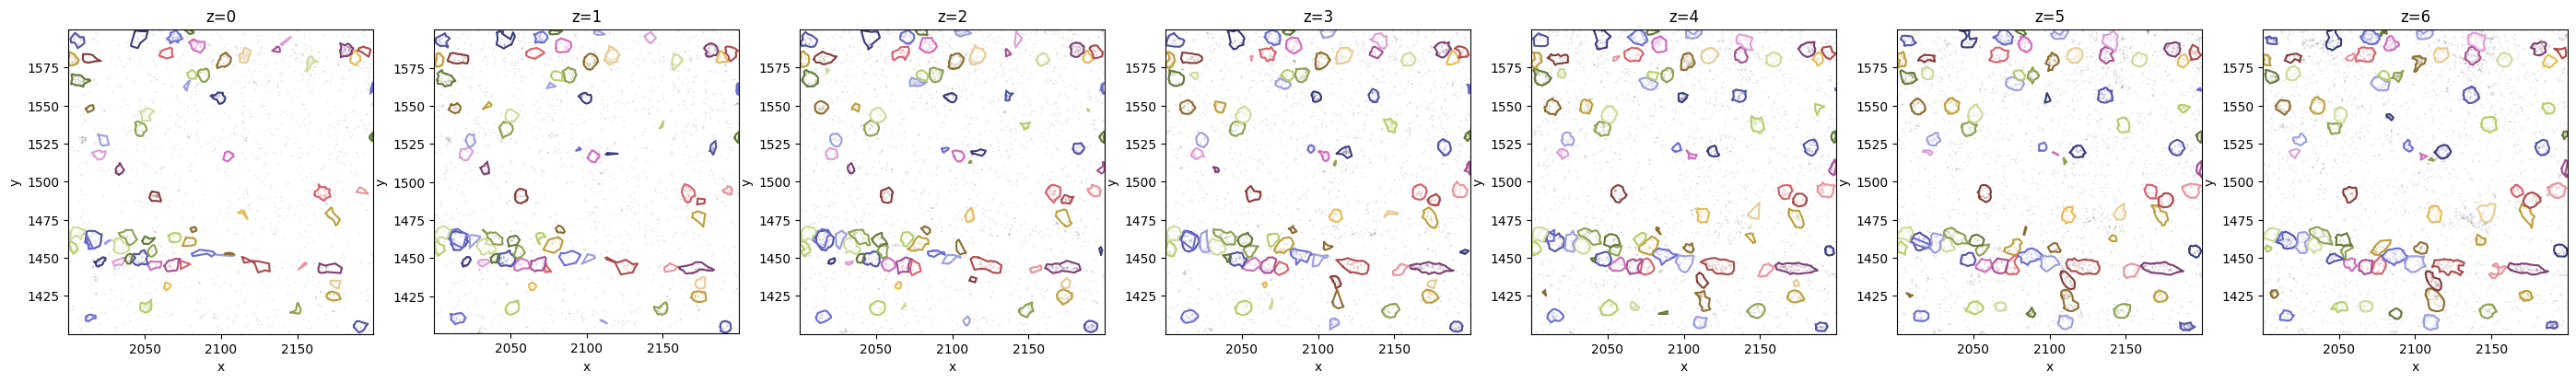

In [22]:
fig, ax = plt.subplots(1, 7, figsize=(35, 5))
for z in range(7):
    segmented_spot_table.cell_scatter_plot(ax=ax[z], show_polygons=True, z_pos=z)
    ax[z].set_title(f'z={z}')

### Run custom Cellpose on a whole section using a hpc

This is the recommended method to run segmentation. It does require a high performance computing cluster with SLURM, but it takes care of everything automatically, including loading the data, distributing segmentation, distributing cell polygons calculation, creating a cell by gene table, and cleaning up any intermediate files.

Note that this method cannot work without tiling the section, so your input section must be larger than your tiles (these default to 200um, though we have been using 350um). Thus for smaller regions (like the previous examples) you must do the segmentation steps manually. Including calculating cell polygons and creating an anndata. These steps are detailed at the bottom of the notebook for reference

### Using the MerscopeSegmentationPipeline class

In [24]:
# Define the path to the model you want to segment with
# This can also be one of ['cyto', 'cyto2', 'nuclei']
path_to_model = str(Path(os.path.abspath('')).parent / "models/CP_20240611_mousedev")

# Define the input and output data
expt_path = Path(os.path.abspath('')) / "merscope_test_data/"
output_dir = Path(os.path.abspath('')) / 'merscope_test_results'
csv_file = expt_path / 'detected_transcripts.csv'
cache_file = expt_path / 'detected_transcripts.csv.npz'
image_path = expt_path / 'images/'

# Pick a subregion to segment on
# The subregion to segment. Set to a string, e.g. 'DAPI', to segment the 
# full region bounded by the associated image channel. To segment a 
# smaller region, set to a tuple corresponding to a bounding box
subrgn = ((2000, 2665), (2000, 2665)) # alternatively: 'DAPI' 
seg_method= sis.segmentation.CellposeSegmentationMethod

# Define the segmentation options as we did for the small region examples above
seg_opts = {
    'cellpose_model': path_to_model,
    'cellpose_gpu': 'auto',
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um
    'z_plane_thickness': 1.5,  # um
    'images': {
        'cyto': {'channel': 'total_mrna', 'n_planes': 7},
        'nuclei': {'channel': 'DAPI', }
    },
    'cellpose_options': {
        'batch_size': 8, 'min_size': 5000
    },
    }

# Define options for the SLURM jobs that will be submitted by the program
# SLURM flags available in hpc_opts include: partition, job-name, nodes, ntasks, array, mincpus, mem,
#                                            gpus-per-node, time, mail-user, mail-type, output, error
# Examples given and commented out below (we recommend letting SIS handle commented out values)
# Additionally hpc_host can be specified in hpc_opts to execute sbatch over ssh rather than with localhost
seg_hpc_opts = {
             # This should be the path to the environment you are using to run this notebook
            'conda_env': 'PATH_TO_CONDA_ENV_FOR_SEGMENTATION', 
            'time': '01:15:00',
            'mem': '30G',
            # 'partition': 'example_partition', 
            # 'job_name': 'segment_merscope',
            # 'nodes': 1,
            # 'ntasks': 1,
            # 'mincpus': 4,
            # 'gpus_per_node': 1,
            # 'mail_user': 'fake_user@gmail.com',
            # 'mail_type': 'END,FAIL',
            # 'output': '/path/to/output/directory/segment_merscope.out',
            # 'error': '/path/to/output/directory/segment_merscope.err',
            # hpc_host: 'login.fakeinstitution.hpc'
            }
polygon_hpc_opts = {
            'num_jobs': 10,
            'conda_env': 'PATH_TO_CONDA_ENV_FOR_SEGMENTATION',
            'time': '01:15:00'}

In [25]:
seg_pipeline = sis.segmentation.MerscopeSegmentationPipeline(csv_file,
                                                             image_path,
                                                             output_dir,
                                                             cache_file,
                                                             subrgn,
                                                             seg_method,
                                                             seg_opts,
                                                             seg_hpc_opts=seg_hpc_opts,
                                                             polygon_hpc_opts=polygon_hpc_opts)

In [26]:
segmented_spot_table, cell_by_gene = seg_pipeline.run(x_format='sparse', overwrite=True, clean_up=True, tile_size=350, min_transcripts=1000)

Loading from npz..
Tiling segmentation region...


  0%|          | 0/2 [00:00<?, ?it/s]

Generating segmentation spec for 4 tiles...
Segmenting tiles...
Job IDs: 25245296_0-3


  0%|          | 0/4 [00:00<?, ?it/s]

Merging tiles...


0it [00:00, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Generating cell polygon spec for 10 jobs...
Calculating cell polygons...
Job IDs: 25245517_0-9


  0%|          | 0/10 [00:00<?, ?it/s]

Merging cell polygons...


  0%|          | 0/10 [00:00<?, ?it/s]

### Steps of the SegmentationPipeline.run function

In [ ]:
x_format='sparse'   # Desired format for the cell by gene anndata X. Options: 'dense' or 'sparse'
prefix=''           # The string to prepend to all cell labels
suffix=''           # The string to append to all cell labels
overwrite=True      # Whether to allow overwriting of output files. Default False.
clean_up='all_ints' # Whether or not to clean up intermediate files after segmentation. Accepts: 'all_ints', 'seg_ints', 'polygon_ints', 'none', True, False, None
tile_size=200       # The maximum size of tiles to segment. Default 200. Increasing this parameter may also require increasing time and/or memory limits in seg_hpc_opts.
min_transcripts=0   # Minimum number of transcripts in a tile to be considered for segmentation
rerun=True          # If enabled, SegmentationPipeline will attempt to automatically rerun jobs that failed. Doubling memory or time when jobs fail due to the respective reasons

# update and save run metadata in case user updated parameters
seg_pipeline.update_metadata()
seg_pipeline.save_metadata(overwrite)

# load the raw spot table corresponding to the segmentation region
seg_pipeline.load_raw_spot_table()

# Tile the raw spot table
tiles, regions = seg_pipeline.tile_seg_region(overwrite=overwrite, max_tile_size=tile_size, min_transcripts=min_transcripts)

# Create dictionary containing segmentation run instructions
seg_run_spec = seg_pipeline.get_seg_run_spec(regions=regions, overwrite=overwrite, result_files=False if clean_up else True)

# SLURM HPC SUBMISSION. ALTERNATIVE RUN METHODS WILL NEED TO REPLACE THESE LINES
seg_pipeline.seg_jobs = seg_pipeline.submit_jobs('segmentation', seg_run_spec, overwrite)
if rerun:
    seg_pipeline.seg_jobs = seg_pipeline.rerun_failed_jobs('segmentation_rerun', seg_pipeline.seg_jobs, seg_run_spec)
cell_ids, merge_results, seg_skipped = seg_pipeline.merge_segmented_tiles(run_spec=seg_run_spec, tiles=tiles, detect_z_planes=seg_pipeline.seg_opts.get('detect_z_planes', None), overwrite=overwrite)

# Create dictionary containing polygon generation instructions
polygon_run_spec = seg_pipeline.get_polygon_run_spec(overwrite)

# SLURM HPC SUBMISSION. ALTERNATIVE RUN METHODS WILL NEED TO REPLACE THESE LINES
seg_pipeline.polygon_jobs = seg_pipeline.submit_jobs('cell_polygons', polygon_run_spec, overwrite)
if rerun:
    seg_pipeline.polygon_jobs = seg_pipeline.rerun_failed_jobs('cell_polygons_rerun', seg_pipeline.polygon_jobs, polygon_run_spec)
cell_polygons, cell_polygons_skipped = seg_pipeline.merge_cell_polygons(run_spec=polygon_run_spec, overwrite=overwrite)

# Create output cell-by-gene
cell_by_gene = seg_pipeline.create_cell_by_gene(x_format=x_format, prefix=prefix, suffix=suffix, overwrite=overwrite)

# Save the segmented spot table
seg_pipeline.save_seg_spot_table(overwrite=overwrite)

# Clean up the intermediate files
if clean_up:
    clean_up = 'all_ints' if clean_up == True else clean_up # If the user decides to input true we'll just set that to all ints
    seg_pipeline.clean_up(clean_up)